# Titanic: The Logic of Survival

![Titanic](https://i.imgur.com/3CsSroz.jpeg)

## A "White Box" Detective Story

In our previous analysis of the `Titanic` dataset, we played the role of a **Data Detective**. We looked at charts, calculated averages, and found patterns like `"Women and children first."`

But knowing *what* happened is different from predicting *what will* happen.

Today, we are upgrading from **Detectives** to **Engineers**. We will build a machine that can look at a passenger's ticket and predict their fate.

### The Goal: End-to-End Machine Learning
This is your first complete Machine Learning project. We will follow the standard 4-step workflow used by data scientists at Google, Netflix, and Amazon:

1.  **Data Preparation:** Formatting the data so the computer can read it (Computers speak numbers, not English).
2.  **The Split:** separating data into "Study Material" and "Exam Material."
3.  **The Model:** Training a **Decision Tree**; a model that learns by creating a flowchart of rules.
4.  **Evaluation:** Grading our model to see if it's actually smart or just guessing.

###  Phase 0. The Setup
First, we need to load our tools. We will use `pandas` for data handling and `sklearn` (Scikit-Learn) for building the brain of our operation.


In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# We will also import the specific tools we need for the model later
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score

# Configuration to make charts look nice
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

#### Inspection (The Health Check)
Before we can train a model, we must interrogate our data. We need to know three things:
1.  **Shape:** How much data do we have?
2.  **Content:** What does the data look like?
3.  **Health:** Are there missing values (holes) in the evidence?

We will use the Seaborn Titanic dataset. Note that this version contains some redundant columns (like `who` and `alive`) which are duplicates of `sex` and `survived`.


In [153]:
# 1. Load the dataset
df = sns.load_dataset('titanic')

# 2. Quick "Health Check"
print(f"Data Shape: {df.shape}")
print("-" * 30)
print("\nMissing Values:")
print(df.isnull().sum())

# 3. Peek at the raw data
df.head()


Data Shape: (891, 15)
------------------------------

Missing Values:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Phase 1. Data Preparation

#### The Cleanup (Triage)
A Machine Learning model is like a calculator; it will crash if you try to feed it "Not a Number" (NaN). Looking at our health check above, we have a few problems:

1.  **`deck`**: Has too many missing values (over 70%). It's too damaged to save. **Decision: Drop it.**
2.  **`age`**: Missing about 177 values. Age is a critical factor for survival. **Decision: Fill missing values with the median age.**
3.  **`embarked`**: Only 2 missing. **Decision: Drop those 2 rows.**
4.  **Redundant Columns**: `embark_town`, `class`, `who`, `adult_male`, `alive` are duplicates provided by Seaborn. **Decision: Drop them to keep it clean.**


In [154]:
# 1. Drop the "Unsalvageable" and "Redundant" columns
df = df.drop(columns=['deck', 'embark_town', 'class', 'who', 'adult_male', 'alive'])

# 2. Drop the 2 rows with missing 'embarked' data
df = df.dropna(subset=['embarked'])

# 3. Fill missing 'age' with the median (Safe bet)
median_age = df['age'].median()
df['age'] = df['age'].fillna(median_age)

# Verify the cleanup
print("Remaining Missing Values:")
print(df.isnull().sum())

Remaining Missing Values:
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
alone       0
dtype: int64


#### Feature Engineering (Translation)
Computers speak math, not English. We cannot feed the model words like "male" or "female." We must translate these into numbers.

*   **Sex:** `male -> 0`, `female -> 1`
*   **Embarked:** `S -> 0`, `C -> 1`, `Q -> 2`

We will also select exactly which features (evidence) we want to show the jury (the Model).


In [155]:
# 1. Translate "Sex" to numbers
df['sex'] = df['sex'].map({'male': 0, 'female': 1})

# 2. Translate "Embarked" to numbers
df['embarked'] = df['embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# 3. sibsp and parch in familysizecol
df['family_size'] = df['sibsp'] + df['parch'] + 1
print('Family size distribution:')

# 4.Count how much pass are in diff family sizes
print(df['family_size'].value_counts().sort_index())
print(f"\nTravelling alone: {(df['family_size'] == 1).sum()} pass")

print(f'\nTravelling with family: {(df['family_size'] > 1).sum()} pass\n')

# 5. astype(int) converts True → 1 and False → 0 so the model can use it
df['is_alone'] = (df['family_size'] == 1).astype(int)
# value_counts() shows how many passengers fall into each category (1 = alone, 0 = with family)
# This helps us understand the distribution of the new 'is_alone' feature.
print(df['is_alone'].value_counts())



# Create age groups as numeric labels: 0=Child, 1=Adult, 2=Senior
df['age_group'] = pd.cut(df['age'],
                         bins=[0, 12, 60, df['age'].max()+1],  # cover all ages
                         labels=[0, 1, 2])
df['age_group'] = df['age_group'].astype(int)


# 7. fare/person
df['fare_person'] = df['fare'] / df['family_size']

# 8.df['is_child'] = (df['age'] < 16).astype(int)
df['priority'] = ((df['sex'] == 1) | (df['age'] < 15)).astype(int)
# 8. expensive vs cheap fare
df['high_fare'] = (df['fare'] > df['fare'].median()).astype(int)



# 3. Define our Features (X) and Target (y)
# X = The questions we ask (Ticket Class, Sex, Age, Fare, etc.)
# y = The answer (Did they survive?)
features = features = ['pclass', 'sex', 'age_group', 'family_size',
                       'high_fare', 'is_alone', 'priority', 'embarked']
X = df[features]
y = df['survived']

# Final check: X should be all numbers now
print("\nFinal Feature Matrix (X):")
X.info()


Family size distribution:
family_size
1     535
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: count, dtype: int64

Travelling alone: 535 pass

Travelling with family: 354 pass

is_alone
1    535
0    354
Name: count, dtype: int64

Final Feature Matrix (X):
<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   pclass       889 non-null    int64
 1   sex          889 non-null    int64
 2   age_group    889 non-null    int64
 3   family_size  889 non-null    int64
 4   high_fare    889 non-null    int64
 5   is_alone     889 non-null    int64
 6   priority     889 non-null    int64
 7   embarked     889 non-null    int64
dtypes: int64(8)
memory usage: 62.5 KB


In [156]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone,family_size,is_alone,age_group,fare_person,priority,high_fare
0,0,3,0,22.0,1,0,7.2500,0,False,2,0,1,3.62500,0,0
1,1,1,1,38.0,1,0,71.2833,1,False,2,0,1,35.64165,1,1
2,1,3,1,26.0,0,0,7.9250,0,True,1,1,1,7.92500,1,0
3,1,1,1,35.0,1,0,53.1000,0,False,2,0,1,26.55000,1,1
4,0,3,0,35.0,0,0,8.0500,0,True,1,1,1,8.05000,0,0


### Phase 2: The Split (Study Material vs. Exam)
This is the most important concept in Machine Learning.

If we teach the model using **all** the data, and then ask it to predict that **same** data, we are cheating. It's like giving a student the answer key to study, and then giving them the exact same questions on the final exam. They will score 100%, but they haven't learned anything; they just memorized the answers.

To test if our model is actually *smart*, we must hide some data from it.
*   **Training Set (80%):** The "Study Guide." The model sees this to learn the rules.
*   **Test Set (20%):** The "Final Exam." The model never sees this until the very end.


In [157]:
# 1. Split the data
# test_size=0.2 means 20% is saved for the "Exam", 80% for "Studying"
# random_state=42 ensures we get the same split every time (reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 2. Check the sizes
print(f"Training Data (Study Guide): {X_train.shape[0]} passengers")
print(f"Test Data (Final Exam):      {X_test.shape[0]} passengers")


Training Data (Study Guide): 666 passengers
Test Data (Final Exam):      223 passengers


### Phase 3: Training the Model
Now we build the brain. We are using a **Decision Tree**.

Imagine a flow chart. The model looks at a passenger and asks:
1.  *"Is this a man?"* (Yes/No)
2.  *"Is he rich (First Class)?"* (Yes/No)
3.  *"Is he a child?"* (Yes/No)

**Crucial Step:** We will set `max_depth=3`.
If we don't limit the depth, the tree will grow wildly complex, creating a specific rule for every single passenger (memorization). Limiting the depth forces it to find the simple, broad rules that apply to everyone (generalization).


In [158]:
# 1. Initialize the "Brain"
# max_depth=3 keeps the tree simple enough to visualize and understand
clf = DecisionTreeClassifier(max_depth=5, random_state=42)

# 2. Teach the model (Fit)
# This is where the magic happens. The model looks at X_train and y_train to find patterns.
clf.fit(X_train, y_train)

print("Model Trained! The detective has learned the rules.")

Model Trained! The detective has learned the rules.


### Phase 4: Visualizing the "Mind" of the Model
This is the best part of using Decision Trees: they are "White Box" models. Unlike Neural Networks, which are mysterious black boxes, we can see exactly how this model thinks.

We will draw the tree it just learned.
*   **Blue boxes:** High probability of survival.
*   **Orange boxes:** High probability of death.
*   **White boxes:** Uncertain (mixed group).

Read the tree from top to bottom. The very first question at the top is the most important rule the model discovered.


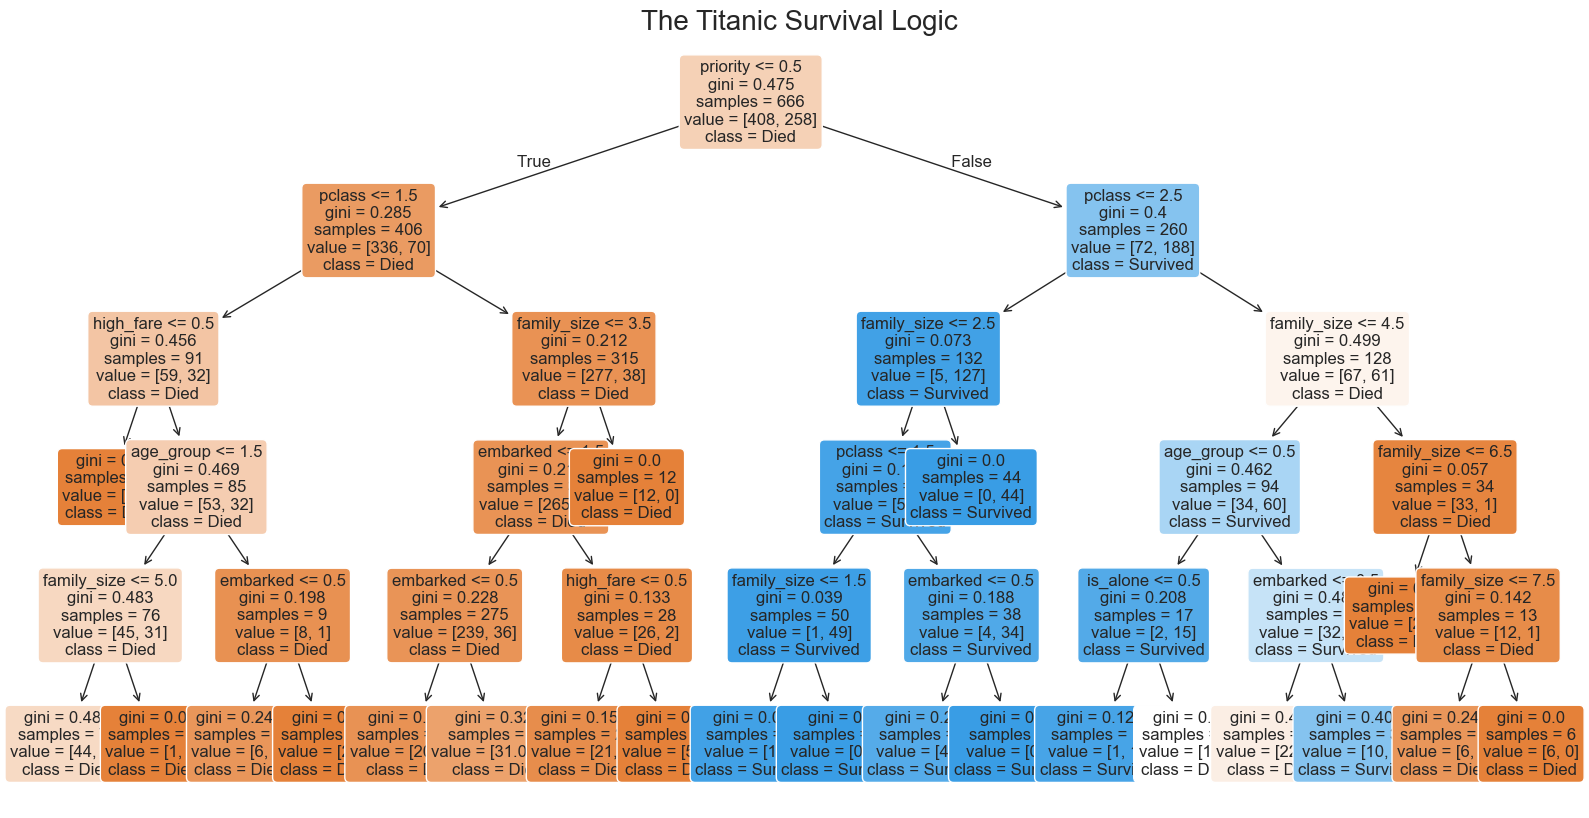

In [159]:
# Plotting the Decision Tree
plt.figure(figsize=(20, 10))  # Make the figure large so we can read the text

plot_tree(clf, 
          feature_names=features,       # Label the questions with feature names (e.g., "sex <= 0.5")
          class_names=['Died', 'Survived'], # Label the answers
          filled=True,                  # Color the boxes (Blue=Survive, Orange=Die)
          rounded=True,                 # Round corners for a nicer look
          fontsize=12)                  # Make text readable

plt.title("The Titanic Survival Logic", fontsize=20)
plt.show()


### Phase 5: The Final Exam (Evaluation)
The tree looks smart, but does it work?
We now give it the **Test Set**: the 20% of passengers we hid earlier. The model will make a prediction for each one, and we will calculate the **Accuracy Score**.

*   **Accuracy:** The percentage of correct predictions (e.g., 0.80 means 80% correct).


In [160]:
# 1. Make predictions on the Test Set
y_pred = clf.predict(X_test)

# 2. Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2%}")
print("-" * 30)

Model Accuracy: 82.96%
------------------------------


In [141]:
# Let's look at a few specific examples from the exam
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head(10))

     Actual  Predicted
281       0          0
435       1          1
39        1          1
418       0          0
585       1          1
804       1          0
343       0          0
836       0          0
581       1          1
537       1          1


### Phase 6: The Ultimate Test (Could Jack Survive?)
We started this story by asking if we could predict survival. Now, let's test our model on the most famous passenger of all: **Jack Dawson**.

We need to create a profile for him based on what we know from the movie:
*   **Class:** 3rd Class (`pclass = 3`)
*   **Sex:** Male (`sex = 0` based on our map)
*   **Age:** 20 (`age = 20`)
*   **Siblings/Spouses:** 0 (`sibsp = 0`)
*   **Parents/Children:** 0 (`parch = 0`)
*   **Fare:** Cheap (`fare = 7.50`)
*   **Embarked:** Southampton (`embarked = 0`)

Let's ask our model the big question.


In [161]:
# Create Jack's features exactly as in training
#features = features = ['pclass', 'sex', 'age_group', 'family_size', 
           # high_fare', 'is_alone', 'priority', 'embarked']

# 1️. Base data for Jack
jack_data = pd.DataFrame({
    'pclass': [3],
    'sex': [0],       # 0 = Male
    'age': [20],
    'sibsp': [0],
    'parch': [0],
    'fare': [7.50],
    'embarked': [0]   # Southampton
})

# 2️. Derived features
jack_data['family_size'] = jack_data['sibsp'] + jack_data['parch'] + 1
jack_data['is_alone'] = (jack_data['family_size'] == 1).astype(int)
jack_data['age_group'] = pd.cut(jack_data['age'],
                                bins=[0, 12, 60, 100],
                                labels=[0, 1, 2]).astype(int)
jack_data['priority'] = ((jack_data['sex'] == 1) | (jack_data['age'] < 15)).astype(int)
jack_data['high_fare'] = (jack_data['fare'] > df['fare'].median()).astype(int)

# 3️. Keep only the features your model expects
jack_data_model = jack_data[features]

# 4️. Predict survival
prediction = clf.predict(jack_data_model)
probability = clf.predict_proba(jack_data_model)

# 5️. Print results
if prediction[0] == 1:
    print("Result: Jack SURVIVED!")
else:
    print("Result: Jack DIED.")

print(f"Survival Probability: {probability[0][1]:.1%}")


Result: Jack DIED.
Survival Probability: 11.9%


## Summary of Our Investigation

Congratulations! You have successfully built your first End-to-End Machine Learning model. Let's review what we achieved today:

1.  **Data Translation:** We took messy, human data ("male", "female", "missing ages") and translated it into a clean matrix of numbers that a computer can understand.
2.  **The Split:** We protected our model from "cheating" by hiding 20% of the data for the final exam.
3.  **The Logic:** We visualized exactly *how* the model makes decisions. We saw that **Sex**, **Class**, and **Age** were the deciding factors—confirming our "Women and Children First" hypothesis from the EDA phase.
4.  **The Result:** We achieved an accuracy score (likely between 78-82%), meaning our simple set of rules can correctly predict the fate of 4 out of 5 passengers.

### "White Box" vs. "Black Box"
Today we used a **Decision Tree**, which is a "White Box" model. You can see every rule it made.
In future lessons, we will use models like **Neural Networks**. They are "Black Boxes"; they might be more accurate, but they won't tell you *why* they made a decision.

### Your Challenge: Can You Beat the Score?
Don't stop here. Your goal is to push the accuracy higher (can you hit 85%?) without changing the model type. Try these three experiments:

1.  **Select Better Features:**
    We used `['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']`.
    *   Does the model get confused by too much information? Try removing `fare` or `embarked`.
    *   Does it need *more* info? Try finding a way to use the `deck` information (if you can fix the missing values).

2.  **Feature Engineering (Create New Data):**
    Sometimes the raw data isn't enough. You can create your own columns!
    *   **Family Size:** Create a new column called `family_size` by adding `sibsp` + `parch`. Does having a large family hurt your chances?
    *   **Age Groups:** Instead of exact age (22, 35, 50), try grouping them into buckets: "Child" (0-12), "Adult" (13-60), "Senior" (60+).

3.  **Tune the "Brain" (Hyperparameters):**
    We set `max_depth=3` to keep the tree simple.
    *   What happens if you increase it to `max_depth=5` or `10`?
    *   **Warning:** If you make the tree too deep, it might memorize the training data (100% score) but fail the exam (low test score). This is called **Overfitting**. Can you find the "sweet spot"?



> *"I figure life's a gift and I don't intend on wasting it. You don't know what hand you're gonna get dealt next. You learn to take life as it comes at you... to make each day count."*
> **Jack Dawson**